In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt # библиотека визуализации

import category_encoders as ce # импорт для работы с кодировщиком
import sweetviz as sv

import re
from collections import Counter

In [76]:
Hotels_df = pd.read_csv('data/hotels.csv')
#Hotels_df.head(3)

In [77]:
#report = sv.analyze(df)
#report.show_html()

In [78]:
df_cl = Hotels_df.copy()

Предварительная анализ данных

In [79]:
# Проверим DF на наличие пропусков
cols_null_percent = df_cl.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

# Наличие пропусков незначительное. Посмотрим какая часть отелей не имеют признака координат
#df_for_nan = df.groupby(by='hotel_name')['lat'].mean()
#hotel_nan = df_for_nan.isnull().sum()/df['hotel_name'].nunique()
#display(hotel_nan)

# удалим строки с пропусками
#df = df.dropna(
#    how='any',
#    axis=0
#)
#df.info()

lat    0.63288
lng    0.63288
dtype: float64

In [80]:
# Проверим DF на дубликаты и удалим их
#dupl_percent = df.duplicated().mean() * 100
#display(dupl_percent)
#df.drop_duplicates(inplace=True)

In [81]:
# Разберем признак hotel_address на признаки Город, Странa и Индекс

df_cl['hotel_country'] = df_cl['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
df_cl['hotel_city'] = df_cl['hotel_address'].apply(lambda x: x.split()[-5] if x.endswith('United Kingdom') else x.split()[-2])
df_cl['hotel_index'] = df_cl['hotel_address'].apply(lambda x: (x.split()[-4]+x.split()[-3]))
df_cl = df_cl.drop(['hotel_address'], axis=1)
#df_cl.info()

In [82]:
# Имея почтовые индексы отелей с проставленными координатами, 
# заполним пропуски в координатах для отелей с такими же почтовыми индексами:
df_mask_index = df_cl.groupby('hotel_index')['lat','lng'].median()
mask1 = df_cl['lat'].isnull()
for h_index in df_cl[mask1]['hotel_index'].unique():
    mask2 = (df_cl['hotel_index'] == h_index)
    df_cl.loc[mask1 & mask2,'lat'] = df_mask_index.loc[h_index,'lat']
    df_cl.loc[mask1 & mask2,'lng'] = df_mask_index.loc[h_index,'lng']

# удалим признак Индекс
df_cl = df_cl.drop(['hotel_index'], axis=1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3468\834062163.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mask_index = df_cl.groupby('hotel_index')['lat','lng'].median()


In [83]:
# Создадим признак
# сity_trevel_rating - рейтинг города по количеству международных прибытий в 2017 году 
# (информация взята https://ru.history-hub.com/10-samyh-poseshaemyh-evropeiskih-gorodov)
сity_trevel_rating = {
    'London': 1, 'Paris': 2, 'Rim': 3, 'Stambul': 4, 'Praga': 5, 'Barcelona': 6,
    'Milan': 7, 'Amsterdam': 8, 'Antalia': 9, 'Vienna': 10
}
# df_cl['сity_trevel_rating'].value_counts(dropna=False)

df_cl['сity_trevel_rating'] = df_cl['hotel_city'].map(сity_trevel_rating)

df_cl = df_cl.drop(['hotel_city'], axis=1)

In [84]:
# Создадим признак form of tourism - форма туризма (0- внутренний, 1 - международный)

df_cl['reviewer_nationality'] = df_cl['reviewer_nationality'].apply(lambda x: x.expandtabs().strip()) # очищаем от лишних пробелов
df_cl['form of tourism'] = np.where(df_cl['reviewer_nationality'] == df_cl['hotel_country'], 0, 1)

df_cl = df_cl.drop(['hotel_country'], axis=1)

In [85]:
data = df_cl.copy()

In [86]:
# Рассмотрим признак review_date

data['review_date'] = pd.to_datetime(data['review_date'])
display('max:', data['review_date'].max())
display('min:', data['review_date'].min())

# Создаем признак month - месяц размещения отзыва
data['month'] = data['review_date'].dt.month

data = data.drop(['review_date'], axis=1)

'max:'

Timestamp('2017-08-03 00:00:00')

'min:'

Timestamp('2015-08-04 00:00:00')

In [87]:
# из признака days_since_review создадим признак its_review_of_last_year(1 - отзыв оставлен менее чем год назад, 0 - более года)
regex = '\d+'
data['its_review_of_last_year'] = np.where(data['days_since_review'].str.findall(regex).str.get(0).astype('int') <=365, 1, 0)

# удалим признак days_since_review
data = data.drop(['days_since_review'],axis=1)

In [88]:
# из признака total_number_of_reviews_reviewer_has_given создадим признак cnt_reviews - количество отзывов
# и cnt_scorts_last_year - количество оценок, данных за прошлый год
mask = (data['its_review_of_last_year'] == 1)
data_mask = data[mask].groupby(by='hotel_name')['total_number_of_reviews_reviewer_has_given'].agg(['max','count'])
data_mask = data_mask.rename(columns={'max': 'cnt_reviews', 'count': 'cnt_scorts_last_year'})

data = data.join(
    data_mask,
    how = 'left',
    on = 'hotel_name'
)
data ['cnt_reviews'] = data['cnt_reviews'].fillna(0)
data ['cnt_scorts_last_year'] = data['cnt_scorts_last_year'].fillna(0)

In [89]:
# Преобразуем признаки negative_review и negative_review в целочисленный тип. (1- поз. нег. эмоция высказана, 
# 0 - эмоция нейтральная) и создадим признаки neg_power и pos_power
# очищаем от лишних пробелов строковые данные, корректируем количество слов в отзывах 
data['negative_review'] = data['negative_review'].apply(lambda x: x.expandtabs().strip().lower()) 
data['review_total_negative_word_counts'] = data['negative_review'].apply(lambda x: len(x.split(' ')))
# выделяем не негативные отзывы
no_negativ_list = ['no negative','no negatives','nothing','n a','none','non','nothing at all','nothing really',
                   'no complaints','all good','na','no','everything was great','Liked everything',
                   'absolutely nothing','everything was perfect','nothing to dislike','not much',
                   'nothing to complain about','nothing not to like','nothing it was lovely','no thing',
                   'nothing to report','not a thing','nothing in particular','all was good','nothing everything was great',
                   'everything was fine','nothing it was perfect','nothing everything was perfect','i liked everything',
                   'liked everything','everything was good','nothing all good','can t think of anything','nil',
                   'nothing to mention','there was nothing we didn t like','loved everything','all ok','nothing i didn t like',
                   'we liked everything','there was nothing to dislike','it was all good','no complaints at all',
                   'nothing comes to mind','there was nothing i didn t like','no problems','nothing to say',
                   'nothing i can think of','no comment','nothing to complain','no issues']
data['negative_review'] = data['negative_review'].apply(lambda x: 0 if x in no_negativ_list else 1).astype('int')
data['neg_power'] = data['negative_review']*data['review_total_negative_word_counts']

data['positive_review'] = data['positive_review'].apply(lambda x: x.expandtabs().strip().lower())
data['review_total_positive_word_counts'] = data['positive_review'].apply(lambda x: len(x.split(' ')))
# выделяем не позитивные отзывы
no_positive_list = ['no positive','nothing','not much']
data['positive_review'] = data['positive_review'].apply(lambda x: 0 if x in no_negativ_list else 1).astype('int')
data['pos_power'] = data['positive_review']*data['review_total_positive_word_counts']

data = data.drop(['negative_review','positive_review','review_total_positive_word_counts','review_total_negative_word_counts'], axis=1)

In [90]:
popular_values = data['reviewer_nationality'].value_counts().nlargest(95).index
data['reviewer_nationality']= data['reviewer_nationality'].apply(lambda x: x if x in popular_values else 'other')

In [91]:
df_tags = data.copy()

In [92]:
df_tags['tags'] = df_tags['tags'].apply(lambda x: ''.join(x[3:-3]).lower().expandtabs().split("', ' "))

In [93]:
tags_list = []
for tags in df_tags['tags']:
    tags_list.extend(tags)
cnt_tags =len(set(tags_list))
counter_tags = Counter(tags_list)
display(cnt_tags)
display(counter_tags.most_common(10))

2395

[('leisure trip ', 313593),
 ('submitted from a mobile device', 230778),
 ('couple ', 189183),
 ('stayed 1 night ', 88083),
 ('solo traveler ', 81224),
 ('business trip ', 61989),
 ('stayed 2 nights ', 59716),
 ('stayed 1 night', 57290),
 ('group ', 49074),
 ('family with young children ', 45828)]

In [94]:
# из признака tags извлечем признак mobile - отзыв отправлен с мобильного девайса (1-да, 0-нет)
def mobil_def(x):
    mobil = [c for c in x if "mobile device" in c]
    str_mobil = 0
    if mobil !=[]:
        str_mobil = 1
        del x[-1]
    return str_mobil 

df_tags['mobil'] = df_tags['tags'].apply(mobil_def)

In [95]:
# из признака tags извлечем признак trip - тип поездки (отдых, деловая, не указано)
def trip_def(x):
    trip = [c for c in x if "trip " in c]
    str_trip = (''.join(trip)).strip()
    if trip !=[]:
        del x[0]
    return str_trip

df_tags['trip'] = df_tags['tags'].apply(trip_def)

# проведем кодировку признака
#ord_encoder = ce.OrdinalEncoder()
#trip_bin = ord_encoder.fit_transform(df_tags[['trip']])
#df_tags = pd.concat([df_tags, trip_bin], axis=1)

In [96]:
# из признака tags извлечем признак stayed_nights - количество ночей
df_tags['tags_del'] = df_tags['tags'].apply(lambda x: ' '.join((''.join(x[-1]).split())[-3:]).split(','))

def nights_def(x):
    nights = [c for c in x if "night" in c]
    str_nights = (''.join(nights)).rstrip(' ')
    return str_nights

df_tags['stayed_nights'] = df_tags['tags_del'].apply(nights_def)
df_tags = df_tags.drop(['tags_del'],axis=1)

In [97]:
def stayed_nights_clean (x):
    rooms = [c for c in x if (("stayed" in c))]
    if rooms !=[]:
        del x[-1:]
    return x

df_tags['tags'] = df_tags['tags'].apply(stayed_nights_clean)

In [98]:
# из признака tags извлечем признак rooms - указанный тип брони
def rooms_def(x):
    rooms = [c for c in x if (("room" in c)or("studio" in c)or("suite" in c)or("lux" in c)or("apartment" in c)or
                                      ("maisonette" in c)or("superior" in c)or("standard" in c)or("double" in c)or
                                      ("duplex" in c)or("king" in c)or("house" in c)or("loft" in c)or("special" in c)or
                                      ("queen" in c)or("garden" in c)or("classi" in c)or("atrium" in c)or
                                      ("apartement" in c)or("park" in c)or("floor" in c)or("corner" in c)or
                                      ("plan" in c)or("cosy" in c)or("bank" in c)or("maison" in c)or
                                      ("twin" in c)or("nest" in c)or("tripl" in c))]
    str_room = (''.join(rooms))
    if rooms !=[]:
        del x[1:]
    return str_room

df_tags['rooms'] = df_tags['tags'].apply(rooms_def)

In [99]:
# создадим признак comfort - форма аренды (0 - стандарт, 1- люкс, делюкс, представительский 2 - улучшенный, 3- полулюкс)
def replace_rooms (x): 
    list_lux = ['delux','executive','suite','luxury','large','premier','privilege']
    for word in list_lux:
        if re.search(word, x):
            return 1 #'deluxe','executive'
    if re.search('superior', x):
        return 2 #'superior'
    elif re.search('junior suite', x):
        return 3 #'junior suite'
    elif re.search('economy', x) or re.search('small', x) or re.search('compact', x) or re.search('accessible', x) :
        return 4 #'economy '    
    else:
        return 0 #'standard', 'classic'

df_tags['comfot'] = df_tags['rooms'].apply(replace_rooms)

In [100]:
# вынесем наличие доп.требований к номеру в отдельныйпризнак (можно его дальше раскрывать, но ограничимся
# 1- требование есть, 0- требования нет)

def add_condition(x):
    add_cond = '  '
    if  re.search('with',x):
        k = re.search('with',x).start()
        add_cond = x[k-1:]
    elif re.search('room',x):
        k = re.search('room',x).end()
        add_cond = x[k+1:]
    elif re.search('suite',x):
        k = re.search('suite',x).end()
        add_cond = x[k:]
    if add_cond =='  ': return 0
    else: return 1
    
df_tags['add_condition']= df_tags['rooms'].apply(add_condition)

In [101]:
# очистим признак room от слов, описывающих комфорт и дополнительные условия
def clean_rooms (x):
    list = ['standard ','classic ','deluxe','executive','superior','junior','luxury','modern',
            'club','comfort','cosy','economy','basic','small','large','marvelous','premier',
            'city','compact','wonderful','special','prestige','premium','accessible',
            'urban','privilege','tradition']
    rez = x.expandtabs(1)
    
    for word in list:
        if re.search(word, x):
            rez = rez.replace(word,'') #re.sub(word,'',x)
            
    if re.search(r'with',rez):
        k = rez.find('with') #re.search(r'with',rez).start()
        rez = rez[:k]
    elif re.search(r'room',rez):
        k = rez.find('room')+3 #re.search(r'room',rez).end()
        rez = rez[:k+1]
    elif re.search(r'suite',rez):
        k = rez.find('suite')+4 #re.search(r'suite',rez).end()
        rez = rez[:k]
    
    return rez.strip()

df_tags['rooms'] = df_tags['rooms'].apply(clean_rooms)

In [102]:
df_tags['trevelers'] = df_tags['tags'].apply(lambda x: ''.join(x[-1]).strip())
df_tags = df_tags.drop(['tags'],axis=1)

In [103]:
df_tags['trevelers'].value_counts()

couple                        188673
solo traveler                  81070
group                          48983
family with young children     45671
family with older children     19731
travelers with friends          1630
leisure trip                     824
business trip                    142
with a pet                        77
premium lafayette                  2
Name: trevelers, dtype: int64

In [104]:
report = sv.analyze(df_tags)
report.show_html()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sweetviz\series_analyzer_cat.py:2

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
ERROR: comet_ml is installed, but not configured properly (e.g. check API key setup). HTML reports will not be uploaded.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3468\3320112557.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tags.corr(),annot = True)


<AxesSubplot: >

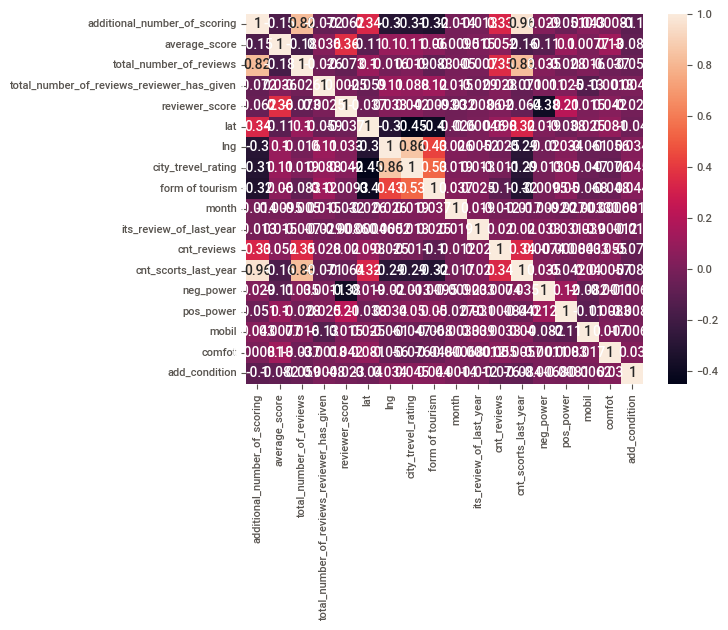

In [105]:
sns.heatmap(df_tags.corr(),annot = True)

In [106]:
# Кодируем названия отелей. Для определения метода кодироки выясним число уникальных значений
# Определим метод кодировки

display(df_cod['hotel_name'].nunique())

# Признак hotel_name номилальный, число признаков больше 15, поэтому применим Двоичное кодирование

bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
name_bin = bin_encoder.fit_transform(df_tags['hotel_name'])
df_tags = pd.concat([df_tags, name_bin], axis=1)

#data.head(2)

KeyError: 'hotel_name'

In [ ]:
# Кодируем reviewer_nationality. Для определения метода кодироки выясним число уникальных значений
# Определим метод кодировки

display(df_tags['reviewer_nationality'].nunique())

# Признак reviewer_nationality номилальный, число признаков больше 15, поэтому применим Двоичное кодирование

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
name_bin = bin_encoder.fit_transform(df_tags['reviewer_nationality'])
df_tags = pd.concat([df_tags, name_bin], axis=1)

In [ ]:
df_tags = df_tags.drop(['hotel_name','reviewer_nationality'], axis=1)

In [ ]:
df_tags.info()

Проведем корреляционный анализ численных признаков

In [ ]:
sns.heatmap(data.corr(), annot = True);

Из матрицы видим сильную корреляционную связь между признаками total_number_of_reviews (общее количество действительных отзывов об отеле) и additional_number_of_scoring (чиисло оценок сервису, но без отзыва).

В силу того, что число оценок без отзывая является подмножеством общего числа оценок, то признак additional_number_of_scoring можем удалить

In [ ]:
df = df.drop(['additional_number_of_scoring'], axis=1)

In [ ]:
df = df.drop(['lat'], axis=1)

In [ ]:
sns.heatmap(df.corr(), annot = True);

1. 

2. 

In [ ]:
#df.info()

In [ ]:
#hotels = indicator_data.copy()

## Создание модели

In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [ ]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

In [ ]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
 

In [ ]:
     
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  


In [ ]:
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))